# Clone the repo:

In [1]:
!git clone https://github.com/MiguelDiLalla/LEGO_Bricks_ML_Vision.git

fatal: destination path 'LEGO_Bricks_ML_Vision' already exists and is not an empty directory.


## Install requeriments:

In [2]:
!pip install -r LEGO_Bricks_ML_Vision/requirements.txt

Defaulting to user installation because normal site-packages is not writeable


### Change repository directory:

In [3]:
import os
os.chdir("LEGO_Bricks_ML_Vision")

In [4]:
!python lego_cli.py --help

Usage: lego_cli.py [OPTIONS] COMMAND [ARGS]...

  LEGO ML CLI - Command Line Interface for training, inference, and dataset
  processing.

Options:
  --help  Show this message and exit.

Commands:
  cleanup          Cleans up temporary directories: - cache/ - logs/ -...
  data-processing  Perform dataset processing tasks.
  infer            Run inference workflows defined in model_utils.
  predict          Run inference on an image.
  train            Train a YOLO model.


### GPU Availability:

In [5]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


CUDA Available: False
GPU Name: CPU


In [6]:
# !python3 lego_cli.py train --mode bricks --epochs 1 --batch-size 16 --no-cleanup --no-show-results


# Show results media:

In [7]:
import os
import cv2
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
import yaml

def display_last_training_session(results_dir="/kaggle/working/LEGO_Bricks_ML_Vision/results"):
    """
    Displays all files from the specified training session directory.
    
    Args:
        session_dir (str): Path to the training session folder.
    """
    if not os.path.exists(results_dir):
        print(f"Results directory not found: {results_dir}")
        return

    print(f"Displaying training session: {results_dir}")
    files = sorted(os.listdir(results_dir))

    for file in files:
        file_path = os.path.join(results_dir, file)
        if file.lower().endswith((".jpg", ".png")):
            print(f"🖼️  Displaying image: {file}")
            image = cv2.imread(file_path)
            if image is None:
                print(f"Unable to load image: {file_path}")
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 10))
            plt.imshow(image)
            plt.axis("off")
            display(plt.gcf())
            plt.close()

        elif file.lower().endswith(".txt"):
            print(f"📄 Displaying text file: {file}")
            with open(file_path, 'r') as f:
                print(f.read())

        elif file.lower().endswith(".csv"):
            print(f"📄 Displaying CSV file: {file}")
            try:
                df = pd.read_csv(file_path)
                display(df)
            except Exception as e:
                print(f"Error reading CSV file {file}: {e}")

        elif file.lower().endswith(".yaml"):
            print(f"📄 Displaying YAML file: {file}")
            try:
                with open(file_path, 'r') as f:
                    content = yaml.safe_load(f)
                pprint(content)
            except Exception as e:
                print(f"Error reading YAML file {file}: {e}")

        else:
            print(f"📄 Skipping unsupported file type: {file}")

    print("✅ Done displaying training session contents.")

# Get the last training session folder path
def get_last_training_session_dir(results_dir="/kaggle/working/LEGO_Bricks_ML_Vision/results"):
    """
    Gets the most recent training session directory based on the timestamp in the folder name.

    Args:
        results_dir (str): Path to the results directory.

    Returns:
        str: Path to the most recent training session directory.
    """
    if not os.path.exists(results_dir):
        print(f"Results directory not found: {results_dir}")
        return None

    session_dirs = [d for d in os.listdir(results_dir) if os.path.isdir(os.path.join(results_dir, d))]
    if not session_dirs:
        print(f"No training session directories found in: {results_dir}")
        return None

    # Sort directories by timestamp in descending order
    session_dirs.sort(reverse=True)
    last_session_dir = os.path.join(results_dir, session_dirs[0])
    return last_session_dir

# Update the display_last_training_session function to use the last training session directory
last_training_session_dir = get_last_training_session_dir()

if last_training_session_dir:
    display_last_training_session(last_training_session_dir)


Results directory not found: /kaggle/working/LEGO_Bricks_ML_Vision/results


## Cleanup Training junk:

In [8]:
# use the clu cleanup command to remove all the training results
!python lego_cli.py cleanup 

2025-02-17 13:07:44,924 - INFO - Cleaning up... ✅
2025-02-17 13:07:44,926 - WARNING - ❌ Not found: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\LEGO_Bricks_ML_Vision\cache ⚠️
2025-02-17 13:07:44,926 - WARNING - ❌ Not found: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\LEGO_Bricks_ML_Vision\results ⚠️


# Testing utils: (inference, prediction, datasets labes traduction, etc)

## Predictions:

In [9]:
import os
import cv2
import matplotlib.pyplot as plt
from IPython.display import display, Image
# from utils.model_utils import load_model, predict
from datetime import datetime
from pprint import pprint
from train import get_repo_root  # import get_repo_root to properly resolve paths
import random

def run_inference(mode="studs"):
    """
    Run inference on a random training image using the specified mode.

    Args:
        mode (str): The mode to use for inference. Default is "studs".
    """
    # Specify the training images directory based on the mode
    if mode == "bricks":
        training_images_dir = "presentation/Test_images/BricksPics"
    elif mode == "studs":
        training_images_dir = "presentation/Test_images/StudsPics"
    else:
        raise ValueError(f"Unsupported mode: {mode}")

    # Select a random training image from the folder
    training_images = [f for f in os.listdir(training_images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if training_images:
        training_image = os.path.join(training_images_dir, random.choice(training_images))
        print(f"Using random training image for inference: {training_image}")
    else:
        raise FileNotFoundError(f"No images found in directory: {training_images_dir}")

    # Load the model
    model = load_model(mode)

    # Retrieve the repository root, and build the absolute results folder path.
    repo_root = get_repo_root()
    results_folder = os.path.join(repo_root, "results")

    # Run inference on the single image; wrap it in a list for batch mode.
    results = predict(
        [training_image],
        model,
        mode=mode,
        batch_size=1,
        save_annotated=True,
        plt_annotated=True,
        results_folder=results_folder
    )

    # Construct the absolute path to the annotated image.
    # Generate a timestamp for the prediction
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    annotated_image_path = os.path.join(results_folder, f"annotated_{timestamp}_" + os.path.basename(training_image))
    if os.path.exists(annotated_image_path):
        print("Displaying annotated inference result with metadata and branding:")
        display(Image(filename=annotated_image_path))
    else:
        print(f"Annotated image not found at: {annotated_image_path}")

    # Print detection metadata
    print("Detection metadata:")
    pprint(results)

# Run inference for both modes
# run_inference("studs")
# run_inference("bricks")

## Clssify bricks:

In [10]:
import os, random

bricks_folder = os.path.join("presentation", "Test_images", "BricksPics")
bricks_images = [os.path.join(bricks_folder, f) for f in os.listdir(bricks_folder) if f.lower().endswith(('.jpg', '.png'))]
bricks_image = random.choice(bricks_images)
print("Using bricks image:", bricks_image)

# Run the CLI command for bricks mode
!python lego_cli.py infer --images "{bricks_image}" --pipeline default --classification-method stud_count

Using bricks image: presentation\Test_images\BricksPics\image_10.jpg

image 1/1 c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\LEGO_Bricks_ML_Vision\presentation\Test_images\BricksPics\image_10.jpg: 640x480 3 bricks, 232.0ms
Speed: 13.0ms preprocess, 232.0ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 480)


2025-02-17 13:08:09,118 - INFO - Running inference workflows... ✅
2025-02-17 13:08:21,810 - INFO - Starting Refactored LEGO Brick Pipeline... ✅
2025-02-17 13:08:21,810 - INFO - 🔹 Loading model: presentation/Models_DEMO/Brick_Model_best20250123_192838t.pt ✅
2025-02-17 13:08:22,689 - INFO - Final composed image saved to: final_outputs\composed\image_10.jpg ✅
2025-02-17 13:08:23,190 - INFO - Composition complete. Outputs: ✅
2025-02-17 13:08:23,190 - INFO - [
    {
        "original": "presentation\\Test_images\\BricksPics\\image_10.jpg",
        "composed": "final_outputs\\composed\\image_10.jpg",
        "annotated": "final_outputs\\annotated\\image_10.jpg",
        "single_visualization": "final_outputs\\single_vis\\image_10.jpg"
    }
] ✅
2025-02-17 13:08:23,190 - INFO - Grid visualization saved at: final_outputs\annotated_grid.jpg ✅


In [11]:
import os, random

studs_folder = os.path.join("presentation", "Test_images", "StudsPics")
studs_images = [os.path.join(studs_folder, f) for f in os.listdir(studs_folder) if f.lower().endswith(('.jpg', '.png'))]
studs_image = random.choice(studs_images)
print("Using studs image:", studs_image)

# Run the CLI command for studs mode
!python lego_cli.py infer --images "{studs_image}" --pipeline default --classification-method stud_count 

Using studs image: presentation\Test_images\StudsPics\image_319_LegoBrick_0_c78.jpg

image 1/1 c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\LEGO_Bricks_ML_Vision\presentation\Test_images\StudsPics\image_319_LegoBrick_0_c78.jpg: 640x416 1 brick, 168.0ms
Speed: 3.0ms preprocess, 168.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 416)


2025-02-17 13:08:43,784 - INFO - Running inference workflows... ✅
2025-02-17 13:08:59,666 - INFO - Starting Refactored LEGO Brick Pipeline... ✅
2025-02-17 13:08:59,666 - INFO - 🔹 Loading model: presentation/Models_DEMO/Brick_Model_best20250123_192838t.pt ✅
2025-02-17 13:09:00,252 - INFO - Final composed image saved to: final_outputs\composed\image_319_LegoBrick_0_c78.jpg ✅
2025-02-17 13:09:00,576 - INFO - Composition complete. Outputs: ✅
2025-02-17 13:09:00,577 - INFO - [
    {
        "original": "presentation\\Test_images\\StudsPics\\image_319_LegoBrick_0_c78.jpg",
        "composed": "final_outputs\\composed\\image_319_LegoBrick_0_c78.jpg",
        "annotated": "final_outputs\\annotated\\image_319_LegoBrick_0_c78.jpg",
        "single_visualization": "final_outputs\\single_vis\\image_319_LegoBrick_0_c78.jpg"
    }
] ✅
2025-02-17 13:09:00,577 - INFO - Grid visualization saved at: final_outputs\annotated_grid.jpg ✅


In [12]:
import os, random

# Reuse the bricks folder for classification
bricks_folder = os.path.join("presentation", "Test_images", "BricksPics")
bricks_images = [os.path.join(bricks_folder, f) for f in os.listdir(bricks_folder) if f.lower().endswith(('.jpg', '.png'))]
classification_image = random.choice(bricks_images)
print("Using classification image:", classification_image)

# Run the CLI command for classify mode
!python lego_cli.py infer --images "{classification_image}" --pipeline default --classification-method stud_count

Using classification image: presentation\Test_images\BricksPics\image_277.jpg

image 1/1 c:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\notebooks\LEGO_Bricks_ML_Vision\presentation\Test_images\BricksPics\image_277.jpg: 480x640 3 bricks, 164.0ms
Speed: 5.0ms preprocess, 164.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


2025-02-17 13:09:17,848 - INFO - Running inference workflows... ✅
2025-02-17 13:09:29,707 - INFO - Starting Refactored LEGO Brick Pipeline... ✅
2025-02-17 13:09:29,708 - INFO - 🔹 Loading model: presentation/Models_DEMO/Brick_Model_best20250123_192838t.pt ✅
2025-02-17 13:09:30,361 - INFO - Final composed image saved to: final_outputs\composed\image_277.jpg ✅
2025-02-17 13:09:30,841 - INFO - Composition complete. Outputs: ✅
2025-02-17 13:09:30,842 - INFO - [
    {
        "original": "presentation\\Test_images\\BricksPics\\image_277.jpg",
        "composed": "final_outputs\\composed\\image_277.jpg",
        "annotated": "final_outputs\\annotated\\image_277.jpg",
        "single_visualization": "final_outputs\\single_vis\\image_277.jpg"
    }
] ✅
2025-02-17 13:09:30,842 - INFO - Grid visualization saved at: final_outputs\annotated_grid.jpg ✅


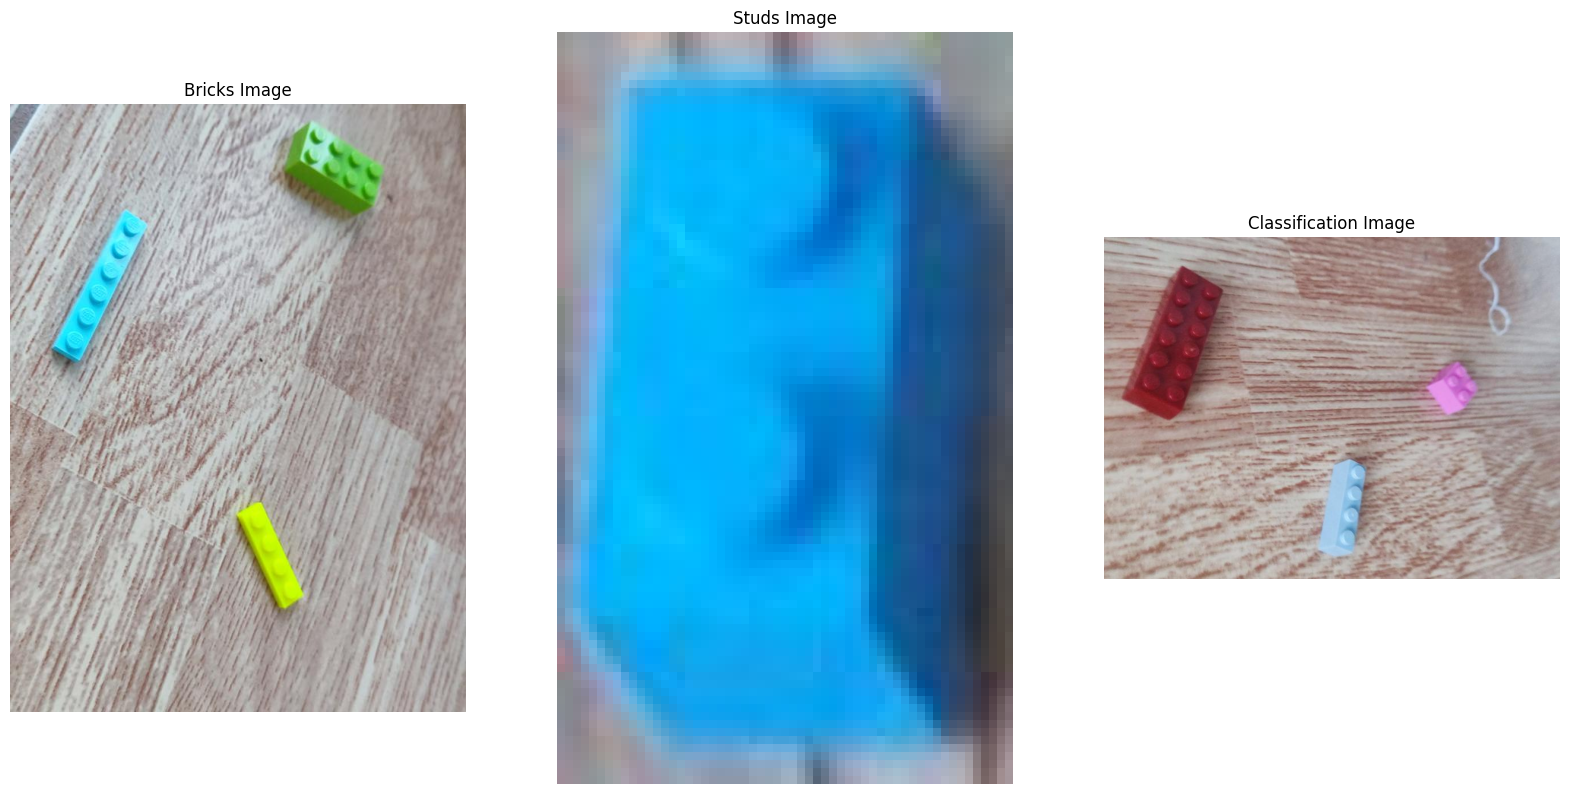

In [ ]:
# # Display the 3 images:
# import cv2

# # Load the images
# bricks_image = cv2.imread(bricks_image)
# studs_image = cv2.imread(studs_image)
# classification_image = cv2.imread(classification_image)

# # Convert the images from BGR to RGB
# bricks_image = cv2.cvtColor(bricks_image, cv2.COLOR_BGR2RGB)
# studs_image = cv2.cvtColor(studs_image, cv2.COLOR_BGR2RGB)
# classification_image = cv2.cvtColor(classification_image, cv2.COLOR_BGR2RGB)

# # Display the images
# plt.figure(figsize=(20, 20))

# plt.subplot(1, 3, 1)
# plt.imshow(bricks_image)
# plt.title("Bricks Image")
# plt.axis("off")

# plt.subplot(1, 3, 2)
# plt.imshow(studs_image)
# plt.title("Studs Image")
# plt.axis("off")

# plt.subplot(1, 3, 3)
# plt.imshow(classification_image)
# plt.title("Classification Image")
# plt.axis("off")

# plt.show()


## Annotation tranformation:

Using random LabelMe JSON for conversion: presentation/Test_Labels/LabelMe_jsons\image_1205.json

Original JSON annotation:
{
  "version": "5.2.1",
  "flags": {},
  "shapes": [
    {
      "label": "LegoBrick",
      "points": [
        [
          393.58974358974365,
          330.7692307692308
        ],
        [
          302.1367521367522,
          405.982905982906
        ]
      ],
      "group_id": null,
      "description": "",
      "shape_type": "rectangle",
      "flags": {}
    },
    {
      "label": "LegoBrick",
      "points": [
        [
          186.75213675213678,
          294.87179487179486
        ],
        [
          132.05128205128204,
          341.02564102564105
        ]
      ],
      "group_id": null,
      "description": "",
      "shape_type": "rectangle",
      "flags": {}
    },
    {
      "label": "LegoBrick",
      "points": [
        [
          686.7521367521367,
          330.7692307692308
        ],
        [
          782.4786324786324,
    

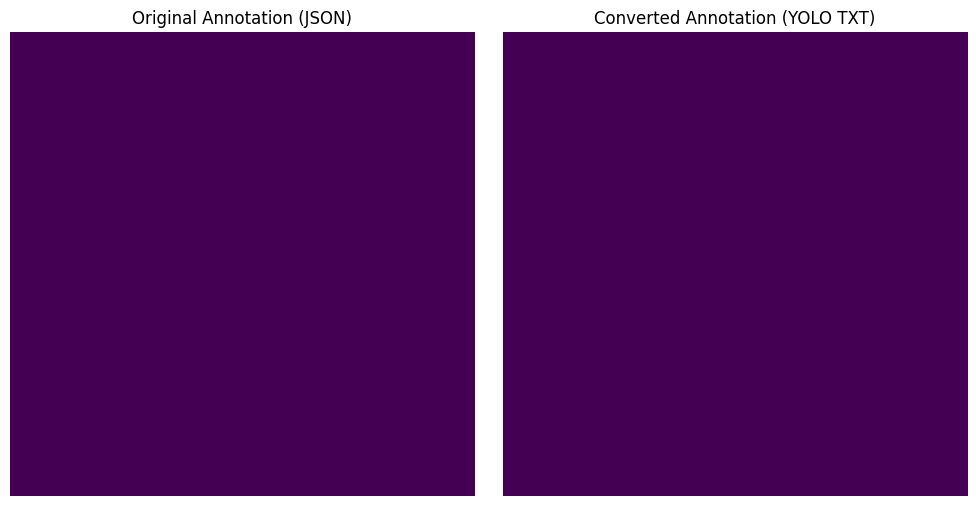

In [14]:
import os, json, random
import matplotlib.pyplot as plt
from IPython.display import display

# Import your conversion function (assumes it is implemented in data_utils.py)
from utils.data_utils import convert_labelme_to_yolo

# Select a random LabelMe JSON file from the presentation/Test_Labels/LabelMe_jsons folder
labelme_dir = "presentation/Test_Labels/LabelMe_jsons"
json_files = [f for f in os.listdir(labelme_dir) if f.endswith(".json")]
if json_files:
    example_file = os.path.join(labelme_dir, random.choice(json_files))
    print(f"Using random LabelMe JSON for conversion: {example_file}")
    
    # Read the original content
    with open(example_file, "r") as f:
        original_content = json.load(f)
    
    # Imitate argparse args for conversion (the conversion function should use the input path and
    # output folder to store the converted file; here we simply run it and then read the output)
    class Args:
        pass
    
    args = Args()
    args.input = labelme_dir
    # Force output to a temporary folder for testing
    output_dir = "results/LabelMe_to_YOLO"
    os.makedirs(output_dir, exist_ok=True)
    args.output = output_dir

    # Run conversion function (if it returns converted content or writes files)
    convert_labelme_to_yolo(args)
    
    # Assume the output file name is similar to the input but with .txt extension
    converted_filename = os.path.basename(example_file).replace(".json", ".txt")
    converted_file = os.path.join(output_dir, converted_filename)
    
    if os.path.exists(converted_file):
        with open(converted_file, "r") as f:
            converted_content = f.read()
    else:
        converted_content = "Conversion did not produce an output file."

    # Pretty print both original and converted results
    print("\nOriginal JSON annotation:")
    print(json.dumps(original_content, indent=2))
    print("\nConverted YOLO annotation text:")
    print(converted_content)
    
    # For visual comparison, create two black images with annotations drawn over.
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Left: raw annotation (simulate by a black image with text)
    axes[0].imshow([[0]])
    axes[0].set_title("Original Annotation (JSON)")
    axes[0].axis("off")
    # Right: converted annotation
    axes[1].imshow([[0]])
    axes[1].set_title("Converted Annotation (YOLO TXT)")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No LabelMe JSON files found in the directory.")

### keipoints to bounding boxes

Using random LabelMe keypoints JSON for conversion: C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\presentation\Test_Labels\Yolo_keipoints\LabelMe_Keipoints_jsons\image_641_LegoBrick_1_c84.json

Original Keypoints JSON:
{
  "version": "5.2.1",
  "flags": {},
  "shapes": [
    {
      "label": "Stud",
      "points": [
        [
          58.660508083140876,
          40.58083140877598
        ]
      ],
      "group_id": null,
      "description": "",
      "shape_type": "point",
      "flags": {}
    },
    {
      "label": "Stud",
      "points": [
        [
          40.300230946882216,
          43.467667436489606
        ]
      ],
      "group_id": null,
      "description": "",
      "shape_type": "point",
      "flags": {}
    },
    {
      "label": "Stud",
      "points": [
        [
          26.905311778290994,
          46.93187066974596
        ]
      ],
      "group_id": null,
      "description": "",
      "shape_type": "point",
      "flags": {}
    },
    {

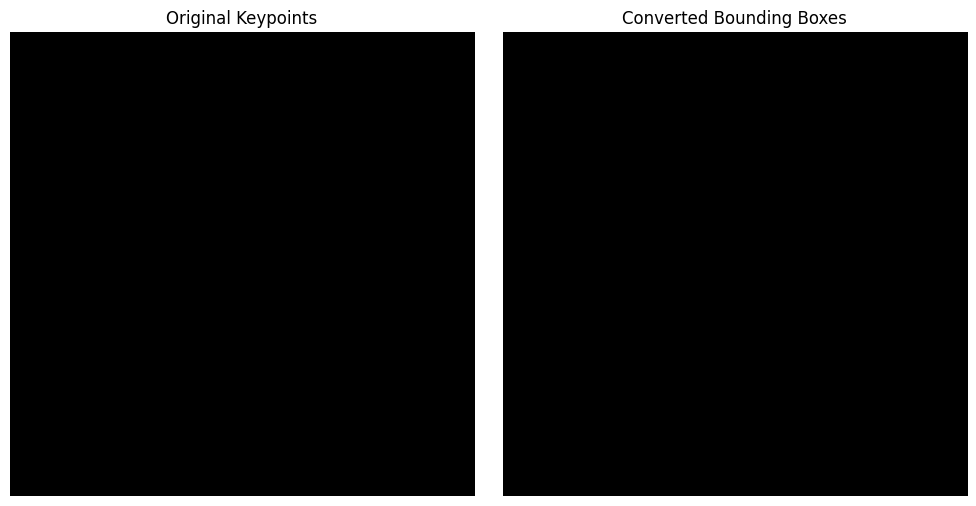

In [15]:
import os, json, random
import matplotlib.pyplot as plt
from IPython.display import display
import math

# Import your keypoint conversion function from data_utils (assumes it is implemented)
from utils.data_utils import convert_keypoints_to_bboxes

# Pick a random LabelMe keypoints JSON file from the appropriate folder
keypoints_dir = r"C:\Users\User\Projects_Unprotected\LEGO_Bricks_ML_Vision\presentation\Test_Labels\Yolo_keipoints\LabelMe_Keipoints_jsons"  # Adjust if keypoint files are in a different folder
json_files = [f for f in os.listdir(keypoints_dir) if f.endswith(".json")]
if json_files:
    example_file = os.path.join(keypoints_dir, random.choice(json_files))
    print(f"Using random LabelMe keypoints JSON for conversion: {example_file}")
    
    # Read original annotations
    with open(example_file, "r") as f:
        original_data = json.load(f)
    
    # Imitate argparse args
    class Args:
        pass
    
    args = Args()
    args.input = keypoints_dir
    # Force output to a temporary folder for testing
    output_dir = "results/Keypoints_to_BBoxes"
    os.makedirs(output_dir, exist_ok=True)
    args.output = output_dir
    args.area_ratio = 0.4  # or any test ratio

    # Run conversion function (it should process keypoints and write bounding boxes)
    convert_keypoints_to_bboxes(args)

    # Assume the output file has the same filename
    converted_file = os.path.join(output_dir, os.path.basename(example_file))
    if os.path.exists(converted_file):
        with open(converted_file, "r") as f:
            converted_data = json.load(f)
    else:
        converted_data = "Conversion did not produce an output file."
    
    # Pretty print both results
    print("\nOriginal Keypoints JSON:")
    print(json.dumps(original_data, indent=2))
    print("\nConverted Bounding Boxes JSON:")
    print(json.dumps(converted_data, indent=2) if isinstance(converted_data, dict) else converted_data)
    
    # Visual comparison with two placeholder black boxes
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow([[0]], cmap="gray")
    axes[0].set_title("Original Keypoints")
    axes[0].axis("off")
    
    axes[1].imshow([[0]], cmap="gray")
    axes[1].set_title("Converted Bounding Boxes")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No LabelMe keypoints JSON files found in the directory.")

#### Repo clone tree monitoring:

In [16]:
import os

def print_folder_tree(startpath=".", indent="    ", max_files=30, preview_files=5):
    """
    Prints the directory tree of the given path in a structured format.

    Args:
        startpath (str): The root directory to print the structure from. Default is current directory.
        indent (str): The indentation format for tree depth.
        max_files (int): Max number of files before compressing the list.
        preview_files (int): Number of files to show from start and end when compressing.
    """
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, "").count(os.sep)
        indent_space = indent * level
        print(f"{indent_space}📂 {os.path.basename(root)}/")  # Print folder name

        sub_indent_space = indent * (level + 1)
        
        # If folder has too many files, compress the list
        if len(files) > max_files:
            files_to_show = files[:preview_files] + ["[...]"] + files[-preview_files:]
        else:
            files_to_show = files  # Show all files if within limit

        for file in files_to_show:
            print(f"{sub_indent_space}📄 {file}")  # Print files inside the folder

# Run the function for your main directory
# print_folder_tree("/kaggle/working/")
